In [5]:
!pip install hmmlearn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\Semhane\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
!pip install torch


   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 1.8/212.5 MB 16.7 MB/s eta 0:00:13
   - -------------------------------------- 10.5/212.5 MB 32.7 MB/s eta 0:00:07
   --- ------------------------------------ 19.4/212.5 MB 36.0 MB/s eta 0:00:06
   ----- ---------------------------------- 28.0/212.5 MB 38.6 MB/s eta 0:00:05
   ------ --------------------------------- 36.7/212.5 MB 38.8 MB/s eta 0:00:05
   -------- ------------------------------- 44.0/212.5 MB 38.4 MB/s eta 0:00:05
   ---------- ----------------------------- 58.2/212.5 MB 42.6 MB/s eta 0:00:04
   ------------- -------------------------- 70.5/212.5 MB 45.9 MB/s eta 0:00:04
   -------------- ------------------------- 75.5/212.5 MB 42.6 MB/s eta 0:00:04
   --------------- ------------------------ 81.5/212.5 MB 42.6 MB/s eta 0:00:04
   ---------------- ----------------------- 88.6/212.5 MB 40.1 MB/s eta 0:00:04
   ------------------ --------------------- 96.5/2


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\Semhane\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # GridSearchCV removed for now
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# New models to import
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Existing models for time series
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes._panel._convert import from_2d_array_to_nested
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary # Make sure this is installed: pip install torchsummary

from scipy.fftpack import fft
import pywt

In [53]:
# ==== Load data ====
train_df = pd.read_csv('Sleep Train 5000.csv', header=None)
test_df = pd.read_csv('Sleep Test 1000.csv', header=None)

In [54]:
# ==== EDA and Visualization (using full raw training data before splits) ====
X_train_full_viz = train_df.iloc[:, 1:].values
y_train_full_viz = train_df.iloc[:, 0].values

def explore_data(df, name="Dataset"):
    print(f"=== {name} Exploration ===")
    print(f"Shape: {df.shape}")
    class_counts = df[0].value_counts()
    print(f"\nClass distribution:")
    print(class_counts)
    print(f"Number of unique classes: {len(class_counts)}")
    print(f"\nMissing values: {df.isnull().sum().sum()}")
    print(f"\nBasic statistics of first few features:")
    print(df.iloc[:, 1:6].describe())
    return class_counts

train_classes_counts = explore_data(train_df, "Training Data")

=== Training Data Exploration ===
Shape: (4999, 179)

Class distribution:
0
2    2000
3    1040
4     751
1     697
0     511
Name: count, dtype: int64
Number of unique classes: 5

Missing values: 0

Basic statistics of first few features:
                 1            2            3            4            5
count  4999.000000  4999.000000  4999.000000  4999.000000  4999.000000
mean     -0.554607    -0.564193    -0.540193    -0.649433    -0.753712
std      17.789305    17.597088    17.681466    17.723401    17.403211
min    -146.094760   -82.371185   -81.849570   -90.543100   -90.803910
25%      -9.345543    -9.258608    -9.519414    -9.693284    -9.432479
50%      -0.391209    -0.652015    -0.652015    -0.738950    -0.738950
75%       8.062149     8.041514     8.215385     8.215385     7.883883
max     105.409035    95.585350    91.934070   109.668860    87.065690


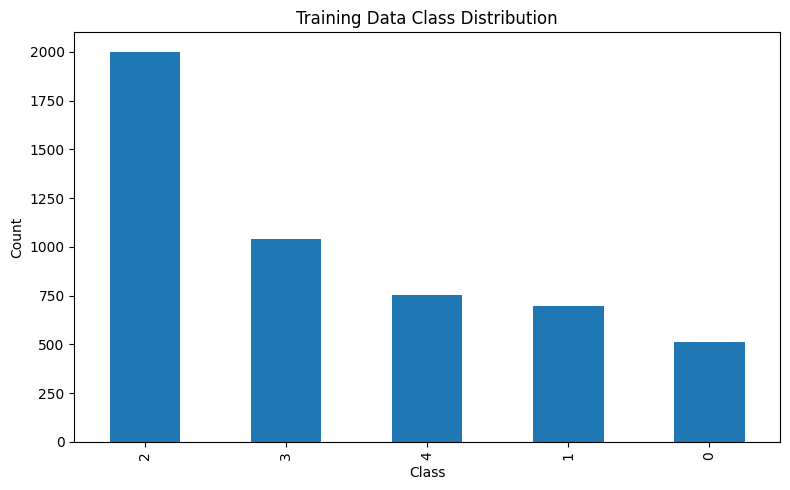

In [55]:
# Visualize class distribution (Optional - comment out if not needed repeatedly)
plt.figure(figsize=(8, 5))
train_classes_counts.plot(kind='bar')
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

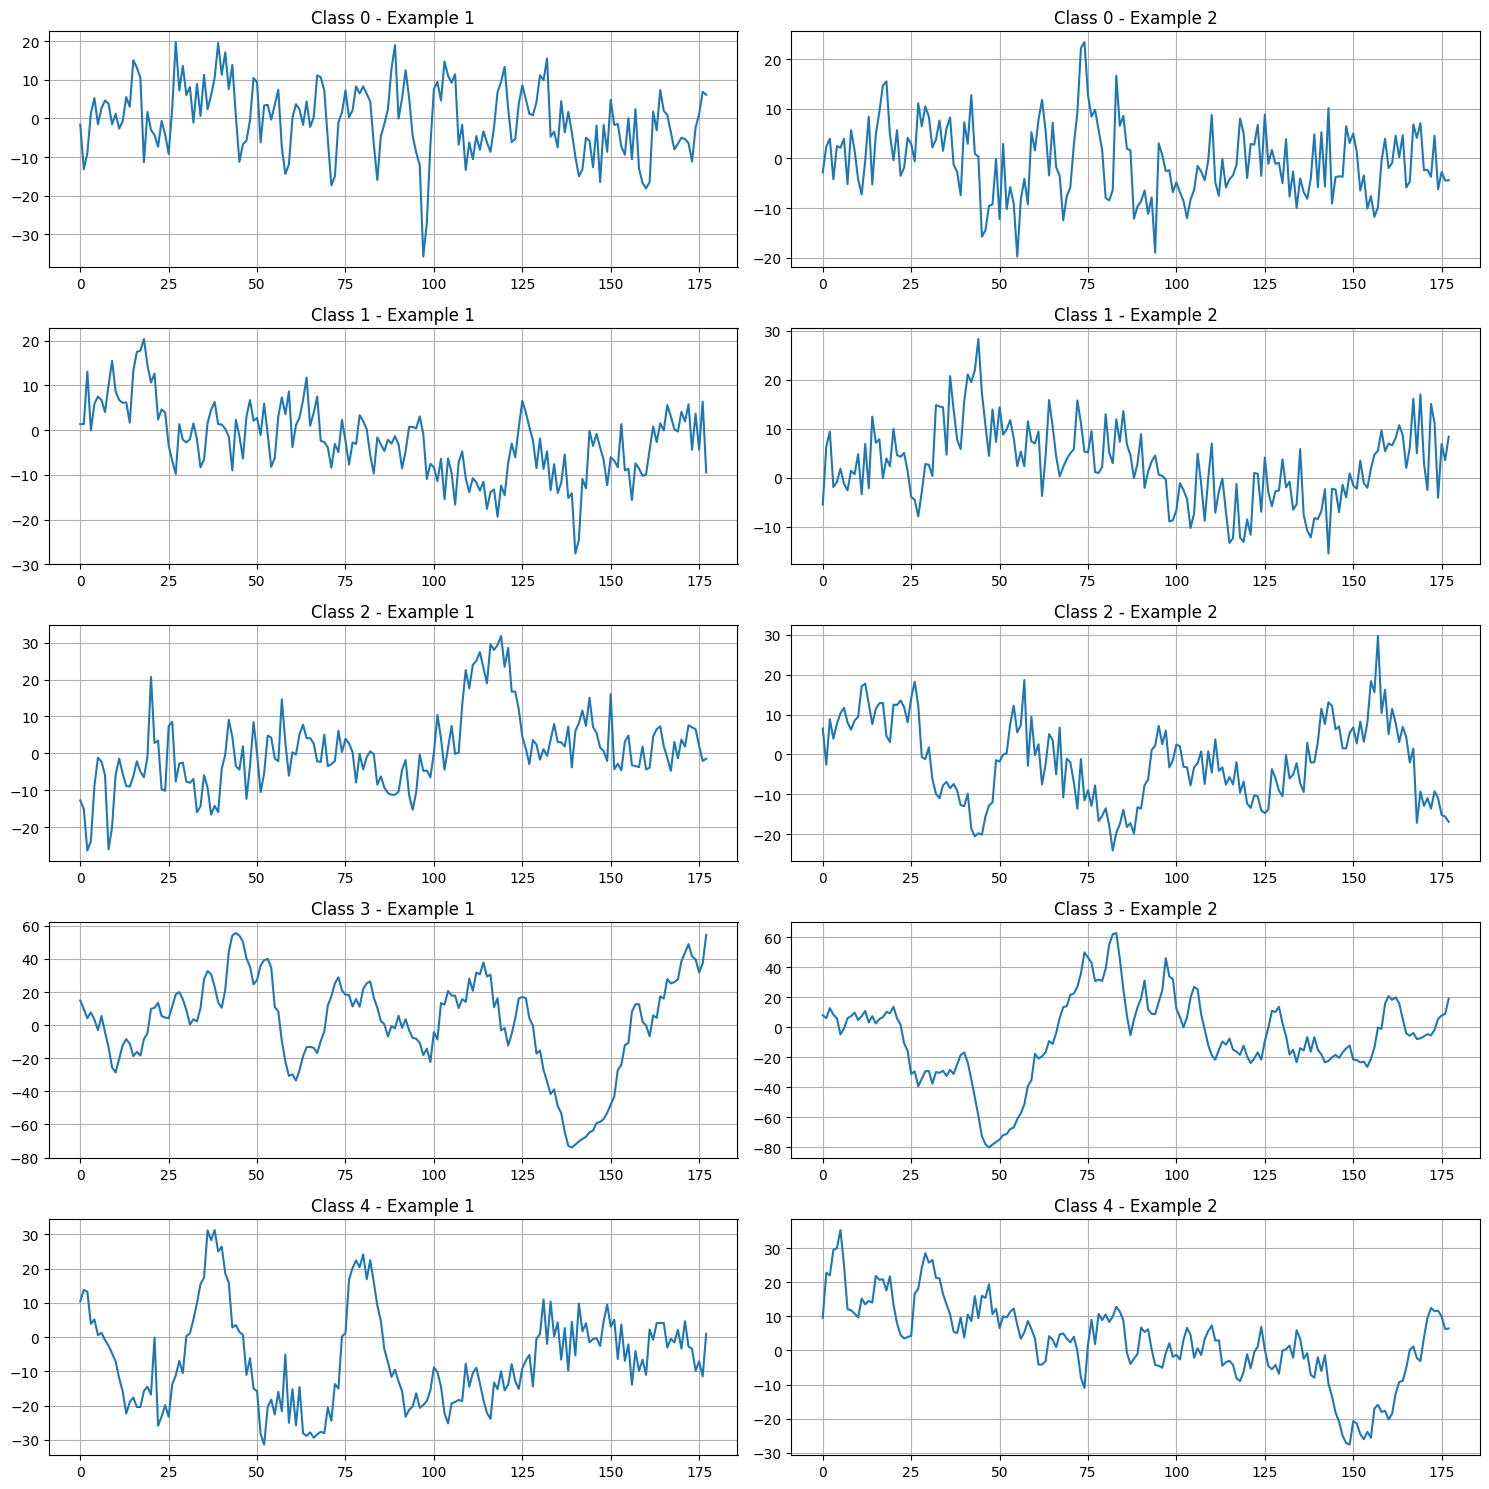

In [56]:
# Visualize a few examples from each class (Optional - comment out if not needed repeatedly)
def plot_examples(X, y, n_examples=2):
    classes = np.unique(y)
    plt.figure(figsize=(15, len(classes)*3))
    for i, cls in enumerate(classes):
        class_indices = np.where(y == cls)[0]
        n_to_plot = min(n_examples, len(class_indices))
        indices_to_plot = class_indices[:n_to_plot]
        for j, idx in enumerate(indices_to_plot):
            plt.subplot(len(classes), n_examples, i*n_examples + j + 1)
            plt.plot(X[idx])
            plt.title(f'Class {cls} - Example {j+1}')
            plt.grid(True)
    plt.tight_layout()
    plt.savefig('class_examples.png')
    plt.show()
plot_examples(X_train_full_viz, y_train_full_viz)


In [57]:
# --- Custom Feature Extraction Functions ---
def extract_stats(X_data):
    features = []
    for signal in X_data:
        mean = np.mean(signal); std = np.std(signal); var = np.var(signal)
        mini = np.min(signal); maxi = np.max(signal); rng = maxi - mini
        median = np.median(signal); skew = 0; kurtosis = 0
        if std > 0:
            skew = np.mean(((signal - mean) / std) ** 3)
            kurtosis = np.mean(((signal - mean) / std) ** 4) - 3
        zero_crossings = np.sum(np.diff(np.signbit(signal - np.mean(signal))))
        peaks = np.sum(np.diff(np.signbit(np.diff(signal))) < 0)
        diffs = np.diff(signal)
        mean_diff = np.mean(diffs) if len(diffs) > 0 else 0
        std_diff = np.std(diffs) if len(diffs) > 0 else 0
        energy = np.sum(signal ** 2); power = energy / len(signal) if len(signal) > 0 else 0
        q25 = np.percentile(signal, 25); q75 = np.percentile(signal, 75); iqr = q75 - q25
        feat = [mean, std, var, mini, maxi, rng, median, skew, kurtosis,
                zero_crossings, peaks, mean_diff, std_diff, energy, power, q25, q75, iqr]
        features.append(feat)
    return np.array(features)

def extract_fft_features(X_data, n_coeffs=50):
    features = []
    for signal in X_data:
        fft_values = np.abs(fft(signal)); dominant_freqs = fft_values[:n_coeffs]
        total_power = np.sum(fft_values ** 2) if np.sum(fft_values ** 2) > 0 else 1
        n_bands = 5; band_size = len(fft_values) // n_bands; band_powers = []
        for i in range(n_bands):
            start = i * band_size; end = (i + 1) * band_size if i < n_bands - 1 else len(fft_values)
            band_power = np.sum(fft_values[start:end] ** 2) / total_power
            band_powers.append(band_power)
        fft_mean = np.mean(fft_values); fft_std = np.std(fft_values)
        fft_max = np.max(fft_values); fft_peak_idx = np.argmax(fft_values)
        feat = np.concatenate([dominant_freqs, band_powers, [fft_mean, fft_std, fft_max, fft_peak_idx]])
        features.append(feat)
    return np.array(features)

def extract_wavelet_features(X_data, wavelet='db4', level=4):
    features = []
    for signal in X_data:
        try:
            coeffs = pywt.wavedec(signal, wavelet, level=level)
        except ValueError: # Simplified error handling for brevity
            wavelet_features = [0.0] * (level + 1) * 3 # Ensure consistent length
        else:
            wavelet_features = []
            for coef in coeffs:
                if len(coef) == 0: wavelet_features.extend([0,0,0]); continue
                wavelet_features.extend([np.mean(coef), np.std(coef), np.sum(coef ** 2)])
        features.append(wavelet_features)
    if features:
        max_len = max(len(f) for f in features)
        features = [f + [0.0] * (max_len - len(f)) if len(f) < max_len else f for f in features]
    return np.array(features)

In [58]:
# ==== Data Preparation ====
X_all_train_raw = train_df.iloc[:, 1:].values
y_all_train_raw = train_df.iloc[:, 0].values
X_test_full_raw = test_df.values

if X_test_full_raw.shape[1] < X_all_train_raw.shape[1]:
    padding = np.zeros((X_test_full_raw.shape[0], X_all_train_raw.shape[1] - X_test_full_raw.shape[1]))
    X_test_full_raw = np.hstack((X_test_full_raw, padding))
elif X_test_full_raw.shape[1] > X_all_train_raw.shape[1]:
    X_test_full_raw = X_test_full_raw[:, :X_all_train_raw.shape[1]]

le = LabelEncoder()
y_all_train_encoded = le.fit_transform(y_all_train_raw)
num_classes = len(le.classes_)

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_all_train_raw, y_all_train_encoded, test_size=0.2, random_state=42, stratify=y_all_train_encoded
)

print("Extracting engineered features for TRAIN data...")
X_train_stats = extract_stats(X_train_raw)
X_train_fft = extract_fft_features(X_train_raw)
X_train_wave = extract_wavelet_features(X_train_raw)
X_train_engineered = np.hstack((X_train_stats, X_train_fft, X_train_wave))

print("Extracting engineered features for VALIDATION data...")
X_val_stats = extract_stats(X_val_raw)
X_val_fft = extract_fft_features(X_val_raw)
X_val_wave = extract_wavelet_features(X_val_raw)
X_val_engineered = np.hstack((X_val_stats, X_val_fft, X_val_wave))

print("Extracting engineered features for TEST data...")
X_test_stats = extract_stats(X_test_full_raw)
X_test_fft = extract_fft_features(X_test_full_raw)
X_test_wave = extract_wavelet_features(X_test_full_raw)
X_test_engineered = np.hstack((X_test_stats, X_test_fft, X_test_wave))

scaler_eng = StandardScaler()
X_train_eng_scaled = scaler_eng.fit_transform(X_train_engineered)
X_val_eng_scaled = scaler_eng.transform(X_val_engineered)
X_test_eng_scaled = scaler_eng.transform(X_test_engineered)
print(f"Shape of engineered train features: {X_train_eng_scaled.shape}")

scaler_ts = StandardScaler()
X_train_ts_scaled = scaler_ts.fit_transform(X_train_raw)
X_val_ts_scaled = scaler_ts.transform(X_val_raw)
X_test_ts_scaled = scaler_ts.transform(X_test_full_raw)

X_train_nested = from_2d_array_to_nested(X_train_ts_scaled)
X_val_nested = from_2d_array_to_nested(X_val_ts_scaled)
X_test_nested = from_2d_array_to_nested(X_test_ts_scaled)

Extracting engineered features for TRAIN data...
Extracting engineered features for VALIDATION data...
Extracting engineered features for TEST data...
Shape of engineered train features: (3999, 92)


In [59]:
# ==== Train Models ====
models = {}
val_accuracies = {}

In [60]:
# --- NEW Set of Traditional Models using Engineered Features ---
print("\nTraining Logistic Regression on engineered features...")
log_reg = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', class_weight='balanced') # Added class_weight
log_reg.fit(X_train_eng_scaled, y_train)
models['Logistic Regression (Eng. Feat.)'] = log_reg


Training Logistic Regression on engineered features...


In [61]:

print("Training Random Forest on engineered features...")
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced', n_jobs=-1) # Added class_weight
rf_clf.fit(X_train_eng_scaled, y_train)
models['Random Forest (Eng. Feat.)'] = rf_clf

Training Random Forest on engineered features...


In [62]:
print("Training SVM on engineered features...")
# SVM can be slow, using fewer iterations for SVC or a linear kernel might be faster
# Using class_weight='balanced' to handle imbalance
svm_clf = SVC(random_state=42, C=1.0, kernel='rbf', class_weight='balanced', probability=False) # probability=True is slow
svm_clf.fit(X_train_eng_scaled, y_train)
models['SVM (Eng. Feat.)'] = svm_clf

Training SVM on engineered features...


In [63]:

print("Training Decision Tree on engineered features...")
dt_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10) # Added max_depth
dt_clf.fit(X_train_eng_scaled, y_train)
models['Decision Tree (Eng. Feat.)'] = dt_clf

Training Decision Tree on engineered features...


In [64]:

print("Training KNN on engineered features...")
knn_clf = KNeighborsClassifier(n_neighbors=7, n_jobs=-1) # Adjusted n_neighbors
knn_clf.fit(X_train_eng_scaled, y_train)
models['KNN (Eng. Feat.)'] = knn_clf

Training KNN on engineered features...


In [65]:
print("Training AdaBoost on engineered features...")
# AdaBoost can benefit from a well-tuned base estimator, default is DecisionTreeClassifier(max_depth=1)
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42, learning_rate=0.1)
ada_clf.fit(X_train_eng_scaled, y_train)
models['AdaBoost (Eng. Feat.)'] = ada_clf

Training AdaBoost on engineered features...


In [66]:
# --- Models using Scaled Time Series Data (Kept from previous version) ---
print("Training TimeSeries Forest on scaled TS data...")
ts_forest = TimeSeriesForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ts_forest.fit(X_train_nested, y_train)
models['TimeSeries Forest (Raw TS)'] = ts_forest

Training TimeSeries Forest on scaled TS data...


In [67]:
# ==== Evaluate on validation (before CNN) ====
print("\nValidation Accuracies (Traditional Models & TSF):")
for name, model in models.items():
    if name == 'TimeSeries Forest (Raw TS)':
        val_preds = model.predict(X_val_nested)
    else:
        val_preds = model.predict(X_val_eng_scaled)
    acc = accuracy_score(y_val, val_preds)
    val_accuracies[name] = acc
    print(f"{name}: {acc:.4f}")


Validation Accuracies (Traditional Models & TSF):
Logistic Regression (Eng. Feat.): 0.6360
Random Forest (Eng. Feat.): 0.6950
SVM (Eng. Feat.): 0.6640
Decision Tree (Eng. Feat.): 0.5800
KNN (Eng. Feat.): 0.6350
AdaBoost (Eng. Feat.): 0.5260
TimeSeries Forest (Raw TS): 0.5660


In [68]:
# --- 1D-CNN Model (PyTorch - Kept from previous version) ---
if torch.cuda.is_available(): device = torch.device("cuda"); print("\nUsing GPU for PyTorch")
else: device = torch.device("cpu"); print("\nUsing CPU for PyTorch")

X_train_cnn = torch.tensor(X_train_ts_scaled.reshape(-1, 1, X_train_ts_scaled.shape[1]), dtype=torch.float32)
y_train_cnn = torch.tensor(y_train, dtype=torch.long)
X_val_cnn = torch.tensor(X_val_ts_scaled.reshape(-1, 1, X_val_ts_scaled.shape[1]), dtype=torch.float32)
y_val_cnn = torch.tensor(y_val, dtype=torch.long)
X_test_cnn_tensor = torch.tensor(X_test_ts_scaled.reshape(-1, 1, X_test_ts_scaled.shape[1]), dtype=torch.float32)

train_dataset = TensorDataset(X_train_cnn, y_train_cnn); val_dataset = TensorDataset(X_val_cnn, y_val_cnn)
test_dataset_cnn = TensorDataset(X_test_cnn_tensor) # Note: This only has X, no y

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False) # For test predictions

class CNN1D(nn.Module):
    def __init__(self, num_features_in, num_classes_out):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 7, padding=3); self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU(); self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, 7, padding=3); self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU(); self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 128, 7, padding=3); self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU(); self.pool3 = nn.MaxPool1d(2)
        with torch.no_grad(): # Dynamic flattening size calculation
            dummy = torch.randn(1, 1, num_features_in)
            dummy = self.pool3(self.relu3(self.bn3(self.conv3(self.pool2(self.relu2(self.bn2(self.conv2(self.pool1(self.relu1(self.bn1(self.conv1(dummy))))))))))))
            flattened_size = dummy.shape[1] * dummy.shape[2]
        self.flatten = nn.Flatten(); self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(flattened_size, 256); self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes_out)
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.flatten(x); x = self.dropout(x)
        x = self.relu4(self.fc1(x)); x = self.fc2(x)
        return x

num_input_features_cnn = X_train_ts_scaled.shape[1]
cnn_model = CNN1D(num_features_in=num_input_features_cnn, num_classes_out=num_classes).to(device)
print(summary(cnn_model, input_size=(1, num_input_features_cnn)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

num_epochs_cnn = 60; best_val_acc_cnn = 0.0; patience_cnn = 15; patience_counter_cnn = 0
print("Training 1D-CNN...")
for epoch in range(num_epochs_cnn):
    cnn_model.train(); running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(); outputs = cnn_model(inputs)
        loss = criterion(outputs, labels); loss.backward(); optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    cnn_model.eval(); val_loss = 0.0; correct = 0; total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn_model(inputs); loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0); correct += (predicted == labels).sum().item()
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs_cnn}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    scheduler.step(epoch_val_loss)
    if epoch_val_acc > best_val_acc_cnn:
        best_val_acc_cnn = epoch_val_acc; torch.save(cnn_model.state_dict(), 'best_cnn_1d_model.pth')
        print(f"New best CNN val acc: {best_val_acc_cnn:.4f}. Model saved."); patience_counter_cnn = 0
    else:
        patience_counter_cnn += 1
        if patience_counter_cnn >= patience_cnn: print("CNN Early stopping."); break
cnn_model.load_state_dict(torch.load('best_cnn_1d_model.pth'))
models['1D-CNN (Raw TS)'] = cnn_model
val_accuracies['1D-CNN (Raw TS)'] = best_val_acc_cnn
print(f"Best 1D-CNN Validation Accuracy: {best_val_acc_cnn:.4f}")


Using CPU for PyTorch
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 178]             256
       BatchNorm1d-2              [-1, 32, 178]              64
              ReLU-3              [-1, 32, 178]               0
         MaxPool1d-4               [-1, 32, 89]               0
            Conv1d-5               [-1, 64, 89]          14,400
       BatchNorm1d-6               [-1, 64, 89]             128
              ReLU-7               [-1, 64, 89]               0
         MaxPool1d-8               [-1, 64, 44]               0
            Conv1d-9              [-1, 128, 44]          57,472
      BatchNorm1d-10              [-1, 128, 44]             256
             ReLU-11              [-1, 128, 44]               0
        MaxPool1d-12              [-1, 128, 22]               0
          Flatten-13                 [-1, 2816]               0
          Dropou

In [69]:
# ==== Final Predictions on Test Set ====
print("\nPredicting on test set and saving results...")
for name, model in models.items():
    if name == 'TimeSeries Forest (Raw TS)':
        preds = model.predict(X_test_nested)
    elif name == '1D-CNN (Raw TS)':
        model.eval(); cnn_test_preds_list = []
        with torch.no_grad():
            for inputs_batch in test_loader_cnn: # Iterate over batches from DataLoader
                inputs_tensor = inputs_batch[0].to(device) # DataLoader wraps data in a list/tuple
                outputs = model(inputs_tensor)
                _, predicted = torch.max(outputs.data, 1)
                cnn_test_preds_list.extend(predicted.cpu().numpy())
        preds = np.array(cnn_test_preds_list)
    else: # Models trained on engineered features
        preds = model.predict(X_test_eng_scaled)
    
    preds_original_labels = le.inverse_transform(preds)
    filename_prefix = name.lower().replace(' (eng. feat.)', '_eng_feat').replace(' (raw ts)', '_raw_ts').replace(' ', '_').replace('(', '').replace(')', '')
    pd.DataFrame(preds_original_labels).to_csv(f"{filename_prefix}_predictions.csv", index=False, header=False)
    print(f"Saved: {filename_prefix}_predictions.csv")

print("\nAll operations complete.")


Predicting on test set and saving results...
Saved: logistic_regression_eng_feat_predictions.csv
Saved: random_forest_eng_feat_predictions.csv
Saved: svm_eng_feat_predictions.csv
Saved: decision_tree_eng_feat_predictions.csv
Saved: knn_eng_feat_predictions.csv
Saved: adaboost_eng_feat_predictions.csv
Saved: timeseries_forest_raw_ts_predictions.csv
Saved: 1d-cnn_raw_ts_predictions.csv

All operations complete.


In [ ]:

print("\nNote on ARIMA and Prophet:")
print("ARIMA and Prophet are primarily forecasting models for univariate time series.")
print("They are not direct classifiers for multiple independent time series samples like the ones used above.")
print("Using them for classification would typically involve a more complex feature engineering step.")

=== Training Data Exploration ===
Shape: (4999, 179)

Class distribution:
0
2    2000
3    1040
4     751
1     697
0     511
Name: count, dtype: int64
Number of unique classes: 5

Missing values: 0

Basic statistics of first few features:
                 1            2            3            4            5
count  4999.000000  4999.000000  4999.000000  4999.000000  4999.000000
mean     -0.554607    -0.564193    -0.540193    -0.649433    -0.753712
std      17.789305    17.597088    17.681466    17.723401    17.403211
min    -146.094760   -82.371185   -81.849570   -90.543100   -90.803910
25%      -9.345543    -9.258608    -9.519414    -9.693284    -9.432479
50%      -0.391209    -0.652015    -0.652015    -0.738950    -0.738950
75%       8.062149     8.041514     8.215385     8.215385     7.883883
max     105.409035    95.585350    91.934070   109.668860    87.065690
Extracting engineered features for TRAIN data...
Extracting engineered features for VALIDATION data...
Extracting enginee